# 10-10. 프로젝트 : 단어 Level로 번역기 업그레이드하기

프로젝트를 진행하기 전에 주요 라이브러리 버전을 확인해 보죠.

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


실습에서 구현한 번역기는 글자 단위(Character-level)에서 구현된 번역기였습니다. 하지만 실제 번역기의 경우에는 글자 단위가 아니라 단어 단위(Word-level)에서 구현되는 것이 좀 더 보편적입니다.

동일한 데이터셋을 사용하면서 글자 단위와는 다른 전처리와 to_categorical() 함수가 아닌 임베딩 층(Embedding layer)를 추가하여 단어 단위의 번역기를 완성시켜보겠습니다. 하지만, 단어 단위로 할 경우에는 단어의 개수가 글자 단위로 했을 경우와 비교하여 단어장의 크기(Vocabulary) 크기도 커지고, 학습 속도도 좀 더 느려집니다. 학습과 테스트 시의 원활한 진행을 위해서 데이터에서 상위 33,000개의 샘플만 사용해주세요.

33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용합니다.

In [2]:
import os
import pandas as pd
import numpy as np
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [3]:
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))

전체 샘플의 수 : 217975


In [4]:
lines = lines[['eng', 'fra']][:33000] # 33000개 샘플 사용
lines[:5]

,eng,fra
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !


In [5]:
lines_np_eng= lines['eng'].to_numpy()
lines_np_fra= lines['fra'].to_numpy()
lines_np_eng

array(['Go.', 'Go.', 'Go.', ..., 'I want to see that.',
       'I want to see them.', 'I want to see this.'], dtype=object)

## Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)
1. 구두점(Punctuation)을 단어와 분리해주세요.

일반적으로 영어권 언어의 경우에는 띄어쓰기 단위로 단어를 분리합니다. 토큰화(Tokenization) 라고도 불리는 이 작업은 어디서부터 어디까지가 하나의 단어인지를 구분하는 작업인데요, 그런데 띄어쓰기를 해주기 전에 구두점을 분리하는 작업이 필요할 때가 있습니다.
예를 들어서 'he is a good boy!'라는 문장이 있을 때, 이를 띄어쓰기 단위로 토큰화한다면 ['he', 'is', 'a', 'good', 'boy!']가 됩니다. 그런데 실제로 !는 boy와 붙어있는 한 단어가 아니므로 좀 더 올바른 전처리는 ['he', 'is', 'a', 'good', 'boy', '!']가 맞습니다.
!나 ? 또는 온점과 같은 특수문자들을 구두점(punctuation)이라고 부릅니다. 이들을 토큰화하기 전에 단어와 미리 분리시켜주세요!

분리 전 : he is a Good boy!
분리 후 : he is a Good boy !

2. 소문자로 바꿔주세요.

기계가 보기에는 스펠링이 같더라도 대문자로 된 단어와 소문자로 된 단어는 서로 다른 단어입니다. 예를 들어 'Good'과 'good'은 기계가 보기에는 다른 단어입니다. 그래서 모든 문장에 대해서 전부 영어로 바꿔주는 작업을 하겠습니다.

    - 변환 전 : he is a Good boy !
    - 변환 후 : he is a good boy !

3. 띄어쓰기 단위로 토큰화를 수행하세요.

띄어쓰기 단위로 토큰화를 수행해서 단어를 분리하는 작업을 해주세요. 기계는 이렇게 분리된 토큰들을 각각 하나의 단어로 인식할 수 있게 됩니다.

    - 토큰화 전 : 'he is a good boy !'
    - 토큰화 후 : ['he', 'is', 'a', 'good', 'boy', '!']

## Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.
글자 단위 번역기를 구현할 때와 마찬가지로 디코더의 입력 시퀀스 맨 앞에는 시작을 의미하는 토큰인 <sos>가 필요합니다. 그리고 교사 강요를 수행할 때, 디코더의 실제값이 되는 디코더의 레이블 시퀀스에는 종료를 의미하는 종료 토큰 <eos>가 필요합니다.
예를 들어 번역 문장이 "Courez!" 였다고 한다면, Step 1을 거친 후에는 다음과 같은 결과를 얻습니다.

- Step 1을 수행한 후 : ['courez', '!']

이 문장에 대해서 각각 디코더의 입력 시퀀스와 레이블 시퀀스를 만들면 다음과 같습니다.

- 입력 시퀀스 : ['< sos >', 'courez', '!']
- 레이블 시퀀스 : ['courez', '!', '< eos >']

참고로 Step 2가 반드시 Step 1이 끝난 후에 이루어질 필요는 없습니다!
Step 1을 수행하는 중간에 수행해도 상관없습니다.

## Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.
딥러닝 모델은 텍스트가 아닌 숫자를 처리합니다. 케라스 토크나이저를 사용해서 각 단어를 고유한 정수로 바꿔보세요.
케라스 토크나이저의 사용법은 아래의 링크에서 2. 케라스(Keras)의 텍스트 전처리에 설명되어 있습니다.

- https://wikidocs.net/31766

위 링크의 가이드를 통해서 영어와 프랑스어에 대한 토크나이저를 각각 생성하고, tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로 변환해보세요.

### 소문자로 바꾸고 구두점을 단어와 분리하기 + 시작 토큰과 종료 토큰 넣기

In [6]:
# 시작 토큰 및 종료 토큰
sos_token = '<start> '
eos_token = ' <end>'

def preprocess_line(line, plus_token = True):
    # 소문자로 변경하기
    line = line.lower().strip()
    # 구두점(Punctuation)을 단어와 분리하기
    line = re.sub(r"([?.!,¿])", r" \1 ", line)
    line = re.sub(r'[" "]+', " ", line)
    line = re.sub(r"[^a-zA-Z?.!,¿]+", " ", line)

    line = line.strip()
    
    if plus_token == True:
        line = sos_token + line + eos_token
    
    return line

### 띄어쓰기 단위로 토큰화 하기 + 텍스트를 숫자로 바꾸기(texts_to_sequences())

In [7]:
def tokenize(corpus):
    tokenizer = Tokenizer(
        num_words=7000,  
        filters=' ',   
        oov_token="<unk>"  
    )
    tokenizer.fit_on_texts(corpus)  

    tensor = tokenizer.texts_to_sequences(corpus)   

    return tensor, tokenizer

### 영어, 프랑스어 전처리하기

In [8]:
eng_lines = []
fra_lines = []

# eng_lines.append(lines.eng.apply(lambda x : preprocess_line(x,plus_token = False)))
# fra_lines.append(lines.fra.apply(lambda x : preprocess_line(x),))

for eng, fra in zip(lines.eng, lines.fra):
    if len(eng) == 0: continue
    if len(fra) == 0: continue   
        
    eng_lines.append(preprocess_line(eng, plus_token = False))
    fra_lines.append(preprocess_line(fra))

In [9]:
np.shape(eng_lines)

(33000,)

In [10]:
eng_tensor, eng_tokenizer = tokenize(eng_lines)
fra_tensor, fra_tokenizer = tokenize(fra_lines)
fra_tensor[:10]

[[2, 74, 10, 3],
 [2, 342, 4, 3],
 [2, 28, 525, 10, 3],
 [2, 680, 10, 3],
 [2, 681, 10, 3],
 [2, 681, 4, 3],
 [2, 655, 10, 3],
 [2, 1630, 10, 3],
 [2, 169, 304, 1103, 304, 2568, 10, 3],
 [2, 1314, 10, 3]]

### input, target

In [11]:
encoder_input = eng_tensor
# 종료 토큰 제거
decoder_input = [[char for char in line if char != fra_tokenizer.word_index['<end>']] for line in fra_tensor]
# 시작 토큰 제거
decoder_target =[[char for char in line if char != fra_tokenizer.word_index['<start>']] for line in fra_tensor]

### padding

In [12]:
def pad_tensor(tensor):
    total_data_text = list(tensor)
    num_tokens = [len(tokens) for tokens in total_data_text]
    max_tokens = max(num_tokens)
    
    maxlen = int(max_tokens)
    tensor = pad_sequences(tensor, padding='post', maxlen=maxlen)  
    return tensor

In [13]:
encoder_input = pad_tensor(encoder_input)
decoder_input = pad_tensor(decoder_input)
decoder_target = pad_tensor(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 16)
프랑스어 출력데이터의 크기(shape) : (33000, 16)


In [14]:
eng_vocab_size = len(eng_tokenizer.word_index)+1
fra_vocab_size = len(fra_tokenizer.word_index)+1

max_eng_seq_len = encoder_input.shape[1]
max_fra_seq_len = decoder_input.shape[1]

In [15]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4516
프랑스어 단어장의 크기 : 7265
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 16


### train, test dataset 나누기


In [16]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [17]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(30000, 8)
(30000, 16)
(30000, 16)
(3000, 8)
(3000, 16)
(3000, 16)


## Step 4. 임베딩 층(Embedding layer) 사용하기
이번에는 입력이 되는 각 단어를 임베딩 층을 사용하여 벡터화하겠습니다.
임베딩 층을 사용하는 방법과 그 설명에 대해서는 아래의 링크의 1. 케라스 임베딩 층(Keras Embedding layer) 을 참고하세요.

- https://wikidocs.net/33793

실제 번역기 구현을 위해서 사용할 수 있는 인코더 코드의 예시는 다음과 같습니다. 이를 통해서 인코더와 디코더의 임베딩 층을 각각 구현해보세요.

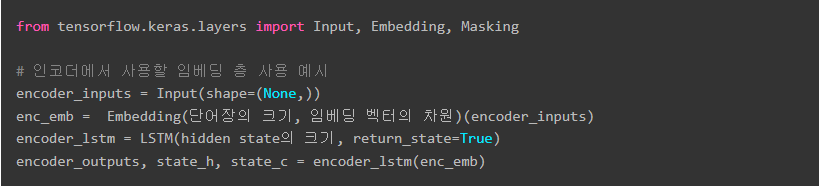

- 참고 : https://wikidocs.net/86900

### 인코더

In [18]:
embedding_size = 512
hidden_size = 512
encoder_inputs = Input(shape=(None, ), name='encoder_input')
enc_emb =  Embedding(eng_vocab_size, embedding_size,
                    input_length=max_eng_seq_len)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(hidden_size, dropout = 0.5, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

### 디코더

In [19]:
decoder_inputs = Input(shape=(None, ), name='decoder_input')
dec_emb =  Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(hidden_size, dropout = 0.5, return_sequences = True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state = encoder_states)

In [20]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [21]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    2312192     encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 512)    3719680     decoder_input[0][0]              
______________________________________________________________________________________________

In [23]:
model.fit(x=[encoder_input_train, decoder_input_train], 
          y=decoder_target_train, 
          validation_data = ([encoder_input_test, decoder_input_test], 
                             decoder_target_test),
          batch_size=32, 
          epochs=50)

Epoch 1/50
938/938 [==============================] - 26s 19ms/step - loss: 1.4289 - val_loss: 1.2010
Epoch 2/50
938/938 [==============================] - 16s 17ms/step - loss: 1.0920 - val_loss: 1.0533
Epoch 3/50
938/938 [==============================] - 16s 17ms/step - loss: 0.9609 - val_loss: 0.9660
Epoch 4/50
938/938 [==============================] - 16s 17ms/step - loss: 0.8731 - val_loss: 0.9081
Epoch 5/50
938/938 [==============================] - 16s 17ms/step - loss: 0.8060 - val_loss: 0.8650
Epoch 6/50
938/938 [==============================] - 16s 17ms/step - loss: 0.7514 - val_loss: 0.8333
Epoch 7/50
938/938 [==============================] - 16s 17ms/step - loss: 0.7117 - val_loss: 0.8195
Epoch 8/50
938/938 [==============================] - 16s 17ms/step - loss: 0.6830 - val_loss: 0.8127
Epoch 9/50
938/938 [==============================] - 16s 17ms/step - loss: 0.6562 - val_loss: 0.7994
Epoch 10/50
938/938 [==============================] - 16s 17ms/step - loss: 0.628

## 모델 구현하기

### 인코더

In [24]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 512)         2312192   
_________________________________________________________________
masking (Masking)            (None, None, 512)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 2099200   
Total params: 4,411,392
Trainable params: 4,411,392
Non-trainable params: 0
_________________________________________________________________


### 디코더

In [25]:
decoder_state_input_h = Input(shape=(embedding_size,))
decoder_state_input_c = Input(shape=(embedding_size,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

In [26]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [27]:
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 512)    3719680     decoder_input[0][0]              
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
____________________________________________________________________________________________

In [28]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <start>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx['<start>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<end>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [29]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' '
    return temp

In [30]:
# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['<start>']) and i!=fra2idx['<end>']):
            temp = temp + idx2fra[i] + ' '
    return temp

## 모델 평가

In [31]:
for seq_index in [1,201,501,1004,2015]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1])

-----------------------------------
입력 문장: i m busy , too . 
정답 문장: je suis galement affair . 
번역기가 번역한 문장:  je suis galemen
-----------------------------------
입력 문장: i need some advice . 
정답 문장: j ai besoin de quelques conseils . 
번역기가 번역한 문장:  j me besoin des d
-----------------------------------
입력 문장: hey , what s up ? 
정답 문장: h ! quoi de neuf ? 
번역기가 번역한 문장:  h , , , ? ? ? ? 
-----------------------------------
입력 문장: how are you now ? 
정답 문장: comment allez vous maintenant ? 
번역기가 번역한 문장:  comment vas vou
-----------------------------------
입력 문장: tom died from tb . 
정답 문장: tom est mort de la tuberculose . 
번역기가 번역한 문장:  tom tom mort mor


## 프로젝트 결과 및 회고
- 이번 프로젝트는 변역기를 만드는 프로젝트 입니다. 데이터를 전처리하고 토큰화 및 패딩을 한 뒤 인코더, 디코더의 형태로 임베딩 층을 사용하여 모델을 구현하였습니다.
- 번역기를 통과한 결과를 확인해본 결과 완벽하게 정답과 일치하지는 않아도 정답 문장의 핵심적인 단어를 언급하는 것을 확인할 수 있었습니다.